# Imports

In [1]:
import numpy as np
import copy
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
%matplotlib inline

# Class Definitions

In [2]:
class DDPG_Agent():
    def __init__(self, state_size, action_size, n_agents, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.hard_update(self.actor_local, self.actor_target)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.hard_update(self.critic_local, self.critic_target)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC)

        # Noise process
        self.noise = OUNoise((n_agents, action_size), random_seed)

        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, random_seed)
        
        # Keep track of time
        self.t = 0
        
    
    def step(self, states, actions, rewards, next_states, dones):
        # Function is able to accept list of lists for all independent agent experiences per timestep and upzip them
        self.t += 1
        # Save experience / reward
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and self.t % UPDATE_FREQUENCY == 0:
            for _ in range(UPDATE_AMOUNT):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        action = np.clip(action,-1,1)
        return action

    def reset(self):
        self.t = 0
        self.noise.reset()

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()
        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
    
    def hard_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(local_param.data)
    
    def save_models(self):
        torch.save(self.actor_local.state_dict(), 'best_actor.pt')
        torch.save(self.critic_local.state_dict(), 'best_critic.pt')
    
    def load_models(self):
        self.actor_local.load_state_dict(torch.load('best_actor.pt'))
        self.critic_local.load_state_dict(torch.load('best_critic.pt'))

In [3]:
class OUNoise:
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = np.random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state  
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

In [4]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed):
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [5]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

In [6]:
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=100, fc2_units=200, fc3_units=100):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.bn0 = nn.BatchNorm1d(state_size)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.bn3 = nn.BatchNorm1d(fc3_units)
        self.out = nn.Linear(fc3_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.out.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        a = self.bn0(state)
        a = F.relu(self.bn1(self.fc1(a)))
        a = F.relu(self.bn2(self.fc2(a)))
        a = F.relu(self.bn3(self.fc3(a)))
        a = torch.tanh(self.out(a))
        return a

In [7]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=200, fc2_units=100, fc3_units=50):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.out = nn.Linear(fc3_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.out.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        v = F.relu(self.fc1(state))
        v = F.relu(self.fc2(torch.cat((v, action), dim=1))) # Action is added to second layers input
        v = F.relu(self.fc3(v))
        v = self.out(v)
        return v

# Hyperparameters

In [8]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 0.001             # for soft update of target parameters
LR_ACTOR = 0.005        # learning rate of the actor 
LR_CRITIC = 0.0005      # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
UPDATE_FREQUENCY = 4
UPDATE_AMOUNT = 1
TRAINING_EPISODES = 500
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random_seed = 0
env_solved = 30
average_over = 100
no_graphics = True

# Setup

Warning: Only run the below cell once!  If you wish to re-initialize the environment after running the below cell you must restart and clear the output of the entire notebook kernel.

In [9]:
env = UnityEnvironment(file_name='Reacher_Windows_x86/Reacher.exe', no_graphics = no_graphics)

brain_name = env.brain_names[0]
env_info = env.reset(train_mode=False)[brain_name]
brain = env.brains[brain_name]

n_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
state_size = len(env_info.vector_observations[0])
agent = DDPG_Agent(state_size, action_size, n_agents, random_seed)

save_models_above = 0
avg_score_history = []

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


# Training The Agent

Running below cell with start the training process using setup from above.

In [10]:
for episode in range(TRAINING_EPISODES):
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    scores = np.zeros(n_agents)
    agent.reset()
    dones = env_info.local_done
    while not np.all(dones):
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        scores += rewards
        agent.step(states, actions, rewards, next_states, dones)
        states = next_states
    avg_score = np.mean(scores)
    avg_score_history.append(avg_score)
    avg_of_avgs = np.mean(avg_score_history[-average_over:])
    if avg_of_avgs > save_models_above:
        save_model_above = avg_of_avgs
        agent.save_models()
        last_episode_models_saved = episode
    if avg_of_avgs > env_solved:
        print("Environment has been solved in", episode, "episodes!")
        break
    if episode % 4 == 0:
        print('Episode:', episode,'Average Score: %.3f' % avg_score, 'Average of Averages: %.3f' % avg_of_avgs)
env.close()

Episode: 0 Average Score: 0.926 Average of Averages: 0.926
Episode: 4 Average Score: 1.274 Average of Averages: 1.095
Episode: 8 Average Score: 1.362 Average of Averages: 1.144
Episode: 12 Average Score: 1.021 Average of Averages: 1.058
Episode: 16 Average Score: 1.041 Average of Averages: 1.008
Episode: 20 Average Score: 1.080 Average of Averages: 1.008
Episode: 24 Average Score: 1.393 Average of Averages: 1.081
Episode: 28 Average Score: 2.404 Average of Averages: 1.204
Episode: 32 Average Score: 3.558 Average of Averages: 1.407
Episode: 36 Average Score: 6.221 Average of Averages: 1.827
Episode: 40 Average Score: 9.243 Average of Averages: 2.526
Episode: 44 Average Score: 14.659 Average of Averages: 3.655
Episode: 48 Average Score: 22.913 Average of Averages: 5.028
Episode: 52 Average Score: 28.139 Average of Averages: 6.577
Episode: 56 Average Score: 31.220 Average of Averages: 8.260
Episode: 60 Average Score: 36.185 Average of Averages: 10.037
Episode: 64 Average Score: 35.604 Ave

# Graphs

In [12]:
print('Last episode model saved:', last_episode_models_saved, 'Average Score:', avg_of_avgs)

Last episode model saved: 128 Average Score: 30.27151432337891


In [13]:
def plot_avg_rewards(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0,i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Average of Previous 100 Rewards for each Episode')
    plt.savefig(figure_file)
    plt.show()

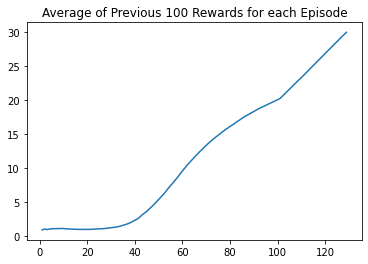

In [20]:
x = [i+1 for i in range(last_episode_models_saved + 1)]
figure_file = 'plots/avg_rewards.png'
plot_avg_rewards(x, avg_score_history, figure_file)

In [21]:
def plot_single_rewards(x, scores, figure_file):
    plt.plot(x, scores)
    plt.title('Reward per Episode')
    plt.savefig(figure_file)
    plt.show()

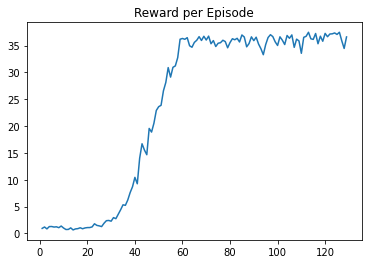

In [23]:
figure_file = 'plots/single_rewards.png'
plot_single_rewards(x, avg_score_history, figure_file)